In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer

import sys
import pathlib
from os.path import join
path_to_file = str(pathlib.Path().resolve())
dir_path = join(path_to_file, "../../")
sys.path.append(join(dir_path, "HelperFiles"))
import helper
import load_data
import train_models
import top_k

# from sprtshap import *
import warnings
warnings.filterwarnings('ignore')
import shap
data_path = join(dir_path, "Experiments", "Data")

In [2]:
X_train, y_train, X_test, y_test, mapping_dict = load_data.load_data(data_path, "breast_cancer")
d = X_train.shape[1]
print(len(y_test), np.mean(y_test))
model = train_models.train_neural_net(X_train, y_train)
# model = train_rf(X_train, y_train)

y_preds = (model(X_test) > 0.5).astype("int")
print("{}% accuracy".format(round(np.mean(y_preds == y_test)*100)))

# SPRT converged here
x_idx = 6
xloc = X_test[x_idx]

171 0.631578947368421
92% accuracy


In [5]:
# method = "rankshap"
# dataset = "breast_cancer"
# K = 5
# guarantee = "rank"
# alpha = 0.1
# data_dir = join(dir_path, "Experiments", "Results", "Top_K", guarantee, "alpha_"+str(alpha)) 
# fname = method + "_" + dataset + "_K" + str(K) 
# path = join(data_dir, fname)

# with open(path, "rb") as fp:
#     results = pickle.load(fp)
    
# top_K_all = results['top_K']
# rejection_idx = results['rejection_idx']
# fwers_all = np.array([calc_fwer(top_K, rejection_idx=idx) for top_K, idx in zip(top_K_all, rejection_idx)])
# print(fwers_all)
# results['x_indices']


30

In [ ]:
import importlib
importlib.reload(top_k)
importlib.reload(helper)

np.random.seed(1)
N_runs = 25
rankshap_vals_all = []
ct = 0
while len(rankshap_vals_all) < N_runs:
    rankshap_vals, _, N, converged = top_k.rankshap(model, X_train, xloc, K=5, alpha=0.1, abs=False, n_samples_per_perm=10, max_n_perms=10000)
    if converged:
        rankshap_vals_all.append(rankshap_vals)
        # if len(rankshap_vals_all) % 5 == 0:
        print("success ", len(rankshap_vals_all))
    ct += 1
    print(ct)

success  1
1
success  2
2
success  3
3
success  4
4
5
success  5
6
success  6
7
success  7
8
success  8
9
10
11
success  9
12
success  10
13
14
success  11
15
success  12
16
success  13
17
success  14
18
success  15
19
success  16
20
21
success  17
22
23
success  18
24
25
26
27
success  19
28
29
success  20
30
success  21
31
success  22
32


In [25]:
order_rs = [helper.get_ranking(shap_values, abs=False) for shap_values in rankshap_vals_all]

K = 5
# cols_rs = []
freqs_rs = []
top_K_rs = np.array(order_rs)[:,:K]
print(helper.calc_fwer(top_K_rs))
for k in range(K):
    most_common = np.argmax(np.bincount(top_K_rs[:,k]))
    # cols_rs.append(colnames[most_common])
    print(most_common) # Verify they're unique
    freqs_rs.append(np.mean(top_K_rs[:,k]==most_common).item())
print(freqs_rs)

0.36
22
13
2
17
0
[1.0, 1.0, 1.0, 0.96, 0.64]


## LIME

In [19]:
x_idx = 1
K = 5
xloc = X_test[x_idx]
top_K_lime = []
from slime import lime_tabular
model = train_model(X_train, y_train, "rf", lime=True)
explainer = lime_tabular.LimeTabularExplainer(X_train, 
                                              discretize_continuous = False, 
                                              feature_selection = "lasso_path", 
                                              sample_around_instance = True)
for _ in range(N_runs):
    exp = explainer.explain_instance(xloc, model, num_features = K, num_samples = 1000) # Default
    tuples = exp.local_exp[1]
    feats = [tuples[i][0] for i in range(5)]
    top_K_lime.append(feats)
print(helper.calc_fwer(top_K_lime))


0.6


### SLIME

In [20]:
top_K_slime = []
while len(top_K_slime) < N_runs:
    exp, converged = explainer.slime(xloc, model, num_features = K, 
                                num_samples = 1000, n_max = 50000, #100000
                                alpha = 0.2/K/2, tol=1e-4, return_none=True)
    if converged:
        tuples = exp.local_exp[1]
        feats = [tuples[i][0] for i in range(K)]
        top_K_slime.append(feats)
print(calc_fwer(top_K_slime))

0.0


In [21]:
# fname = "lime_vs_slime"
# with open(join(dir_path, "Experiments", "Results", "alpha0.2", fname), "rb") as fp:
#         top_Ks = pickle.load(fp)
# top_K_lime, top_K_slime = np.array(top_Ks[0]), np.array(top_Ks[1])
top_K_lime, top_K_slime = np.array(top_K_lime), np.array(top_K_slime)

###### Get frequencies of top-5 lime and S-LIME features
cols_lime = []
freqs_lime = []
K = 5
breast_cancer = load_breast_cancer()
colnames = breast_cancer.feature_names
for k in range(K):
    most_common = np.argmax(np.bincount(top_K_lime[:,k]))
    cols_lime.append(colnames[most_common])
    print(most_common) # Verify they're unique
    freqs_lime.append(np.mean(top_K_lime[:,k]==most_common))
print(freqs_lime)

cols_slime = []
freqs_slime = []
for k in range(K):
    most_common = np.argmax(np.bincount(top_K_slime[:,k]))
    cols_slime.append(colnames[most_common])
    print(most_common) # Verify they're unique
    freqs_slime.append(np.mean(top_K_slime[:,k]==most_common))

print(freqs_slime)

22
23
20
7
27
[np.float64(1.0), np.float64(0.96), np.float64(0.6), np.float64(0.44), np.float64(0.76)]
22
23
20
7
27
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


## Visualize

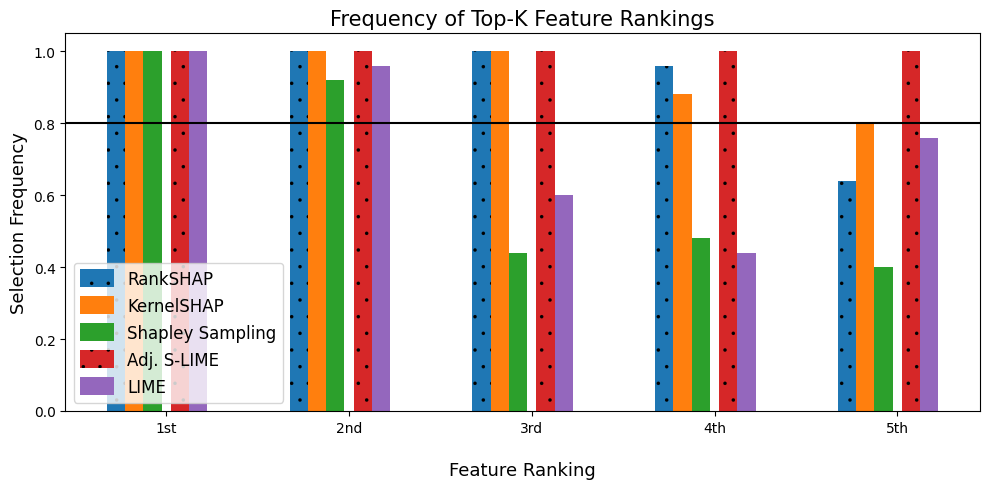

In [22]:
plt.figure(figsize=(10,5))
width = 0.1

# Plotting
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth

onetoK = np.arange(K)+1
plt.bar(onetoK-.225, freqs_rs , width, label='RankSHAP', hatch=".")
plt.bar(onetoK-.125, freqs_kshap , width, label='KernelSHAP')
plt.bar(onetoK-.025, freqs_ss, width, label='Shapley Sampling')

plt.bar(onetoK+.125, freqs_slime , width, label='Adj. S-LIME', hatch=".")
plt.bar(onetoK+.225, freqs_lime, width, label='LIME')

plt.xlabel('\nFeature Ranking', size=13)
plt.ylabel('Selection Frequency', size=13)
plt.title('Frequency of Top-K Feature Rankings', size=15)

order = ["1st", "2nd", "3rd", "4th", "5th"]
# order2 = [order[i] + '\n' + cols_slime[i].title() for i in range(K)]
plt.xticks(onetoK + width / 2, order)
plt.axhline(0.8, color="black")
# Finding the best position for legends and putting it
plt.legend(loc='lower left', prop={'size': 12}, handleheight=1.3)
plt.tight_layout()
# plt.savefig(join(dir_path, "Experiments", "Figures", "instability.png"), bbox_inches="tight")
plt.show()
